## Note: I didn't run the maps because otherwise the notebook gets over 100MB and that's to big to push to github (:

## Importing packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import json 
from urllib import request
import plotly.express as px
import plotly.graph_objs as go
import plotly
import os

In [3]:
# graph settings
%matplotlib inline
matplotlib.rcParams['font.sans-serif'] = "Helvetica"
matplotlib.rcParams['font.family'] = "sans-serif"

## Loading and cleaning data

In [4]:
df = pd.read_csv('Evictions.csv')

In [5]:
df.head()

,Court Index Number,Docket Number,Eviction Address,Eviction Apartment Number,Executed Date,Marshal First Name,Marshal Last Name,Residential/Commercial,BOROUGH,Eviction Postcode,Ejectment,Eviction/Legal Possession,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA
0,48174/18,349487,1238 BOYNTON AVENUE,1R,03/08/2019,Thomas,Bia,Residential,BRONX,10472,Not an Ejectment,Possession,40.829759,-73.878482,9.0,18.0,54.0,2025234.0,2.037740e+09,West Farms-Bronx River
1,B35706/18,108013,3235 GRAND CONCOURSE,6C,10/03/2018,Darlene,Barone,Residential,BRONX,10468,Not an Ejectment,Possession,40.877488,-73.885258,7.0,11.0,411.0,2017667.0,2.033230e+09,Bedford Park-Fordham North
2,55095/17,10840,640 E 86TH STREET,NaN,07/25/2017,Edward,Guida,Residential,BROOKLYN,11236,Not an Ejectment,Possession,40.640733,-73.911547,18.0,46.0,958.0,3223963.0,3.079900e+09,Canarsie
3,Q72651/16,75106,148-41 236 STREET,NaN,03/31/2017,Ileana,Rivera,Residential,QUEENS,11422,Not an Ejectment,Possession,40.653782,-73.747053,13.0,31.0,694.0,4443919.0,4.137360e+09,Springfield Gardens South-Brookville
4,64094/17,11817,38-32 29TH STREET,1,08/16/2017,Edward,Guida,Residential,QUEENS,11101,Not an Ejectment,Possession,40.754198,-73.933916,1.0,26.0,31.0,4004669.0,4.003850e+09,Queensbridge-Ravenswood-Long Island City


In [6]:
df['Executed Date'] = df['Executed Date'].apply(pd.to_datetime)

In [7]:
df['Marshal Full Name'] = df['Marshal First Name'] + ' ' + df['Marshal Last Name']

In [8]:
df = df.copy().dropna(subset=['NTA'])

In [9]:
# load data from directories and declare with variable name
myVars = vars()
def load_data(directory, data):
    for filename in os.listdir(directory):
        # filter out hidden files because they start with .
        if not filename.startswith('.'):
            # assign following name
            variable_name = "_".join(filename.split("_", 2)[:2])
            data.append(variable_name)
            myVars[variable_name] = pd.read_excel(directory+'/'+filename)
            year = int(variable_name.split("_")[1])
            myVars[variable_name]['year'] = year
            if year == 2017:
                myVars[variable_name] = myVars[variable_name].rename(columns={'GeoName': 'NTA'})
            else:
                myVars[variable_name] = myVars[variable_name].rename(columns={'GeogName': 'NTA'})
    return data

In [10]:
# load all of the asc survey data
directories = ['housing_data', 'economic_data', 'social_data', 'demographic_data']
data = []
for directory in directories:
    data = load_data(directory, data)

In [11]:
# load the nta boundaries for 2010 NTA's
# https://data.cityofnewyork.us/City-Government/NTA-map/d3qk-pfyz
with open('NTA_map.geojson') as file:
    nta_json = json.load(file)

for i in list(range(len(nta_json['features']))):
    json_id = nta_json['features'][i]['properties']['ntaname']
    nta_json['features'][i]['id'] = json_id

In [12]:
# loading the nta boundaries for 2020 NTA's
url = 'https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/NYC_Neighborhood_Tabulation_Areas_2020/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson'
with request.urlopen(url) as response:
    nta_json_2020 = json.load(response)

for i in list(range(len(nta_json_2020['features']))):
    json_id = nta_json_2020['features'][i]['properties']['NTAName']
    nta_json_2020['features'][i]['id'] = json_id

In [13]:
# see what NTA's are not in json file
def check_nta_matches(nta_json, data):
    nta_list = []
    for i in list(range(len(nta_json['features']))):
        nta_list += [nta_json['features'][i]['id']]

    missing = 0
    same = 0
    for nta in data['NTA'].unique():
        if nta not in nta_list:
            missing += 1
            print('The following NTA is not in the json file:', nta)
        else: same += 1
    print('Same:',same)
    print('Missing:',missing)

In [14]:
check_nta_matches(nta_json, df)

Same: 191
Missing: 0


In [15]:
check_nta_matches(nta_json, hous_2017)

The following NTA is not in the json file: Hudson Yards-Chelsea-Flat Iron-Union Square
Same: 194
Missing: 1


In [16]:
# replace name of NTA in asc survey data with name used in eviction dataset and json file
for file in data:
    myVars[file] = myVars[file].replace('Hudson Yards-Chelsea-Flat Iron-Union Square', 'Hudson Yards-Chelsea-Flatiron-Union Square')

In [17]:
check_nta_matches(nta_json_2020, hous_2019)

Same: 262
Missing: 0


## Basic stats

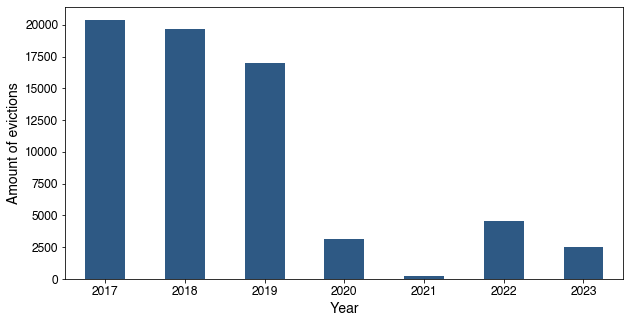

In [18]:
plt.figure(figsize=(10,5))
df.groupby(df['Executed Date'].dt.year)['Executed Date'].count() \
    .plot(kind='bar', color='#2E5984')
plt.xlabel('Year', size='14')
plt.ylabel('Amount of evictions', size='14')
plt.xticks(rotation=0, size='12')
plt.yticks(size='12')
plt.show()

Eviction during covid stopped (https://hcr.ny.gov/covid-19-eviction-protections-tenants)

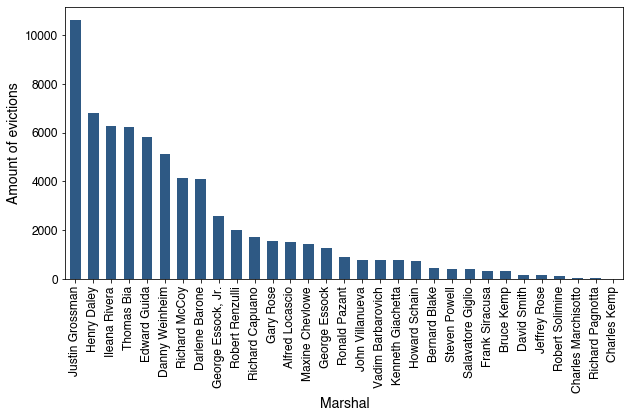

In [19]:
df.groupby(df['Marshal Full Name'])['Executed Date'].count() \
    .sort_values(ascending=False) \
    .plot(kind='bar', color='#2E5984', figsize=(10,5), width=0.6)
plt.xlabel('Marshal', size='14')
plt.ylabel('Amount of evictions', size='14')
plt.xticks(rotation=90, size='12')
plt.yticks(size='12')
plt.show()

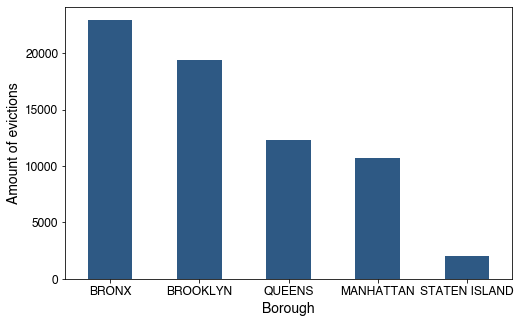

In [20]:
df.groupby(df['BOROUGH'])['Executed Date'].count() \
    .sort_values(ascending=False) \
    .plot(kind='bar', color='#2E5984', figsize=(8,5))
plt.xlabel('Borough', size='14')
plt.ylabel('Amount of evictions', size='14')
plt.xticks(rotation=0, size='12')
plt.yticks(size='12')
plt.show()

## Evictions on map

In [21]:
map_data = df.groupby([df['Executed Date'].dt.year,'NTA'])['NTA'].count()
map_data = map_data.rename('Evictions').to_frame().reset_index()
map_data = map_data.rename(columns={'Executed Date': 'Year'})

In [ ]:
fig = px.choropleth_mapbox(map_data, geojson=nta_json, locations='NTA', color='Evictions',
                        color_continuous_scale="agsunset_r",
                        #range_color=(map_data['Evictions'].min(), map_data['Evictions'].max()),
                        mapbox_style="carto-positron",
                        zoom=9.2, center = {"lat": 40.72, "lon": -73.93},
                        labels={'random':'random'}, 
                        animation_frame='Year',
                        width=950,
                        height=600
                        )
fig.update_traces(marker_line_width=0.5, marker_opacity=0.6)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

## Map to compare data 

In [22]:
hous2017_focus = hous_2017[['NTA', 'MdGRE', 'GRnoRntPdE']]
hous2017_focus = hous2017_focus.rename(columns={'MdGRE':'Mean rent', 'GRnoRntPdE':'GRAPI'})

In [23]:
map_data_2 = df.groupby(['NTA'])['NTA'].count()
map_data_2 = map_data_2.rename('Evictions').to_frame().reset_index()

In [24]:
merge = pd.merge(map_data_2, hous2017_focus, left_on=['NTA'], right_on=['NTA'], how='left')

In [ ]:
# mapbox_access_token = 'pk.eyJ1IjoiZnJhbnppMTI2IiwiYSI6ImNsZ3NiYnJhdzB2NTQzcG1rdzc0dmo4c2sifQ.8jxznVULScBVloaDu5Xhlw'

cols_dd = ["Evictions", 'Mean rent', 'GRAPI']

fig = go.Figure(go.Choroplethmapbox(
        z=merge['Evictions'], 
        geojson=nta_json, 
        locations=merge['NTA'],
        #hoverinfo='all',
        text = merge['NTA'],
        hovertemplate = '<b>NTA</b>: <b>%{text}</b>'+'<br><b>Evictions</b>: %{z}<br>',
        marker_line_width=0.5, 
        marker_opacity=0.6,
        colorscale="agsunset_r"))

fig.update_layout(
    margin={"r":0,"t":0,"l":0,"b":0},
    title= f'Title',
    autosize=True,
    hovermode='closest',
    showlegend=False,
    width=950,
    height=600,
    mapbox=dict(
    #accesstoken=mapbox_access_token,
        bearing=0,
        center={"lat": 40.72, "lon": -73.93},
        pitch=0,
        zoom=9.2,
        style="carto-positron"
        )) 

#Gross rent as a percentage of household income
button1 = dict(method='update',
              label='Evictions',
              args=[{'z':[merge['Evictions']]}])
button2 = dict(method='update',
              label='Average rent',
              args=[{'z':[merge['Mean rent']]}])
button3 = dict(method='update',
              label='GRAPI',
              args=[{'z':[merge['GRAPI']]}])

fig.update_layout(updatemenus=[dict(active=0,
                                    buttons=[button1, button2, button3])])
#fig.show()

## Rent in NYC

In [ ]:
# test nta map 2020 with new boundaries
fig = px.choropleth_mapbox(hous_2020, geojson=nta_json_2020, locations='NTA', color='MdGRE',
                           color_continuous_scale="agsunset_r",
                           #range_color=(map_data['Evictions'].min(), map_data['Evictions'].max()),
                           mapbox_style="carto-positron",
                           zoom=9.2, center = {"lat": 40.72, "lon": -73.93},
                           opacity=0.6,
                           labels={'random':'random'}, 
                           #animation_frame='Year',
                           width=950,
                           height=600
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_traces(marker_line_width=0.5, marker_opacity=0.6)
#fig.show()

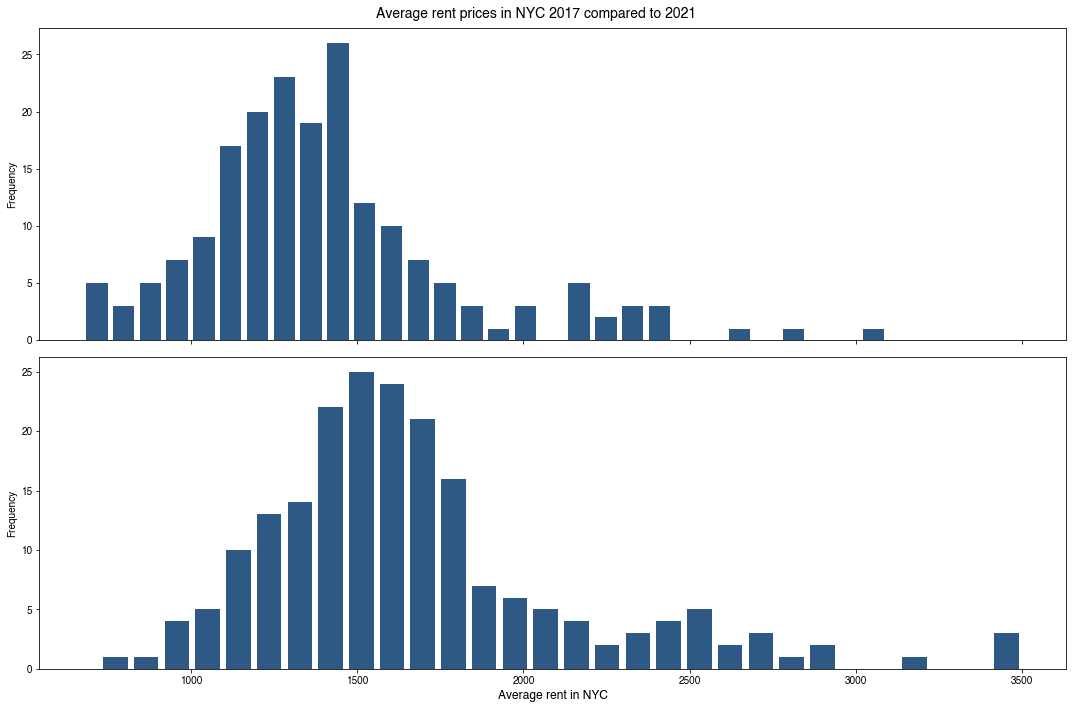

In [25]:
fig, axs = plt.subplots(2,1,figsize=(15,10), sharex=True)
fig.suptitle('Average rent prices in NYC 2017 compared to 2021', size=14)
hous_2017['MdGRE'].plot(bins=30, kind='hist', color='#2E5984', rwidth=0.8, ax=axs[0])
hous_2021['MdGRE'].plot(bins=30, kind='hist', color='#2E5984', rwidth=0.8, ax=axs[1])
plt.xlabel('Average rent in NYC', size=12)
fig.tight_layout()
plt.show()

In [26]:
# average rent 2017
rent2017 = hous_2017['MdGRE'].mean()
print(rent2017)

1407.4607329842931


In [27]:
# average rent 2021
rent2021 = hous_2021['MdGRE'].mean()
print(rent2021)

1677.2892156862745


In [28]:
print(f"Increase of {round(rent2021/rent2017-1, 3)*100}% in average rent from 2017 to 2021")

Increase of 19.2% in average rent from 2017 to 2021


### Average rent vs Income

In [29]:
hous_combined = pd.concat([hous_2017, hous_2018, hous_2019, hous_2020, hous_2021], axis=0)

In [30]:
hous_combined = hous_combined.dropna(subset=['MdGRE'])

In [31]:
rent_mean = hous_combined.groupby(['year'])['MdGRE'].mean().to_frame().rename(columns={'MdGRE':'Average rent'}).reset_index()

In [32]:
econ_combined = pd.concat([econ_2017, econ_2018, econ_2019, econ_2020, econ_2021], axis=0)

In [33]:
econ_combined = econ_combined.dropna(subset=['MnHHIncE'])

In [34]:
income_mean = econ_combined.groupby(['year'])['MnHHIncE'].mean().to_frame().rename(columns={'MnHHIncE':'Average income'}).reset_index()

<AxesSubplot:>

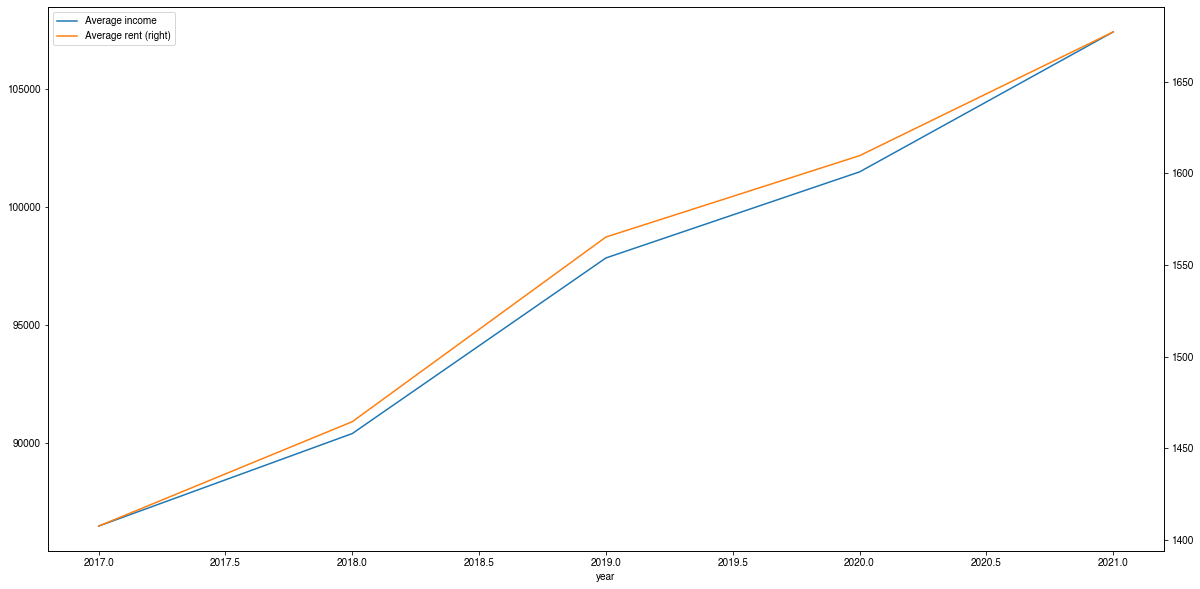

In [35]:
fig, ax = plt.subplots(figsize=(20,10)) 

income_mean.plot(x = 'year', y='Average income', ax = ax) 
rent_mean.plot(x='year', y='Average rent', ax = ax, secondary_y = True)
#evictions_dev.plot(x='year', y='amount', ax = ax, secondary_y = True )